In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import root_mean_squared_error
import os


In [44]:
def montar_dataframe(dados_brutos: dict, peso_vazio: list | np.ndarray) -> pd.DataFrame:
    """
    Gera um DataFrame a partir de dados experimentais de peso.
    
    Parâmetros:
        dados_brutos (dict): Dicionário onde cada chave é o valor de 'Passos'
                             e o valor é uma lista com os 'Pesos com líquido'.
        peso_vazio (list | np.ndarray): Lista com os valores de 'Peso(g)' (vazio),
                                        repetidos para cada tentativa.
                                        
    Retorna:
        pd.DataFrame: Contendo colunas ['Passos', 'Peso(g)', 'Peso com líquido(g)', 'Peso do líquido(g)'].
    """

    peso_vazio = np.array(peso_vazio)

    # Criação dos arrays combinados
    passos = np.repeat(list(dados_brutos.keys()), len(peso_vazio))
    peso = np.tile(peso_vazio, len(dados_brutos))
    peso_liquido = np.concatenate([dados_brutos[k] for k in dados_brutos])

    # Calcula o peso do líquido (diferença)
    peso_liquido_real = peso_liquido - peso

    # Monta o DataFrame
    df = pd.DataFrame({
        'Passos': passos,
        'Peso(g)': peso,
        'Peso com líquido(g)': peso_liquido,
        'Peso do líquido(g)': peso_liquido_real
    })

    return df




def fit_micropipeta(df,limx=None,limy=None,densidade=0.997):

    df_copy = df.copy()

    df_copy['Peso água(g)']=df_copy['Peso com líquido(g)']-df_copy['Peso(g)']
    passos = df_copy['Passos']
    peso_agua =df_copy['Peso água(g)']
   

    densidade_agua = densidade  # g/mL
    volume_agua = (peso_agua / densidade_agua) * 1000  # μL
    df_copy['Volume experimental (µL)'] = (df_copy['Peso água(g)'] / densidade_agua) * 1000

    passos_unicos = np.unique(passos)
    volumes_media = np.array([np.mean(volume_agua[passos == p]) for p in passos_unicos])
    volumes_media = np.round(volumes_media)
    volumes_std = np.array([np.std(volume_agua[passos == p]) for p in passos_unicos])

    slope, intercept, r_value, p_value, std_err = linregress(passos_unicos, volumes_media)
    print(f"y = {slope:.5f}x + {intercept:.5f} (μL)")
    print(f"R² = {r_value**2:.5f}\n")

    volumes_fit = slope * passos_unicos + intercept

    rmse = root_mean_squared_error(volumes_media,volumes_fit)
    print(f"RMSE = {rmse:.5f}")

    plt.figure(figsize=(8,5))
    plt.errorbar(passos_unicos, volumes_media, yerr=volumes_std, fmt='o', capsize=5, ecolor='red', label='Média ± desvio padrão')
    plt.plot(passos_unicos, volumes_fit, 'b--', label=f'Fit Linear: y={slope:.5f}x+{intercept:.5f} μL')
    plt.xlabel("Passos")
    plt.ylabel("Volume de água (μL)")
    plt.title("Volume de água vs Passos com Fit Linear")
    plt.legend()
    plt.grid(True)
    if not(limx==None):
        plt.xlim(limx)
    
    if not(limy==None):
        plt.ylim(limy)

    plt.show()

    return df_copy



def validar_micropipeta(df_teste, nome, limx=None, limy=None):
    """
    Valida dados experimentais de uma micropipeta e salva os resultados:
    - Gráfico PNG
    - Resumo estatístico (TXT)
    - DataFrame completo (XLSX)
    """

    # Criar pasta de saída
    pasta = nome.strip().replace(" ", "_")
    os.makedirs(pasta, exist_ok=True)

    # Cópia do DataFrame original
    df_copy = df_teste.copy()

    # Cálculos principais
    densidade_agua = 0.997  # g/mL
    df_copy['Peso água (g)'] = df_copy['Peso com líquido (g)'] - df_copy['Peso (g)']
    df_copy['Volume experimental (µL)'] = (df_copy['Peso água (g)'] / densidade_agua) * 1000

    # Cálculo dos erros
    df_copy['Erro absoluto (µL)'] = df_copy['Volume experimental (µL)'] - df_copy['Valor teórico']
    df_copy['Erro relativo (%)'] = (df_copy['Erro absoluto (µL)'] / df_copy['Valor teórico']) * 100

    # Estatísticas agrupadas
    resumo = df_copy.groupby('Valor teórico')[['Volume experimental (µL)', 'Erro absoluto (µL)', 'Erro relativo (%)']].agg(['mean', 'std'])

    # ======== GRÁFICO ========
    fig, ax = plt.subplots(figsize=(8,5))
    ax.errorbar(
        resumo.index,
        resumo['Volume experimental (µL)']['mean'],
        yerr=resumo['Volume experimental (µL)']['std'],
        fmt='o',
        capsize=5,
        ecolor='red',
        label='Experimental (média ± desvio padrão)'
    )

    ax.set_xlabel('Volume teórico (µL)')
    ax.set_ylabel('Volume medido (µL)')
    ax.set_title('Validação Experimental da Micropipeta')
    ax.legend()
    ax.grid(True)

    # Forçar formato numérico normal
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    ax.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.tick_params(axis='both', which='major', labelsize=10)

    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)

    if limx is not None:
        ax.set_xlim(limx)
    if limy is not None:
        ax.set_ylim(limy)

    # Salvar gráfico
    caminho_grafico = os.path.join(pasta, f"{pasta}_grafico.png")
    plt.savefig(caminho_grafico, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Fecha para liberar memória

    # ======== SALVAR RESUMO E DADOS ========

    # Resumo em TXT
    caminho_txt = os.path.join(pasta, f"{pasta}_resumo.txt")
    with open(caminho_txt, "w", encoding="utf-8") as f:
        f.write("Resumo estatístico por volume teórico:\n")
        f.write(resumo.to_string())
        f.write("\n")

    # DataFrame completo em Excel
    caminho_excel = os.path.join(pasta, f"{pasta}_dados.xlsx")
    df_copy.to_excel(caminho_excel, index=False)


    return df_copy

In [45]:

dados_brutos = {
    10:   [2.146,2.192,2.152,2.173,2.246,2.282],
    32.3: [2.221,2.266,2.225,2.246,2.319,2.357],
    32.4: [2.223,2.268,2.228,2.249,2.321,2.359],
    32.6: [2.226,2.271,2.230,2.250,2.323,2.360],
    50:   [2.281,2.327,2.286,2.307,2.379,2.418],
    75:   [2.366,2.414,2.371,2.391,2.464,2.502],
    89.6: [2.421,2.466,2.421,2.444,2.517,2.553],
    100:  [2.455,2.501,2.458,2.481,2.552,2.590],
    125:  [2.540,2.586,2.546,2.567,2.639,2.677],
    150:  [2.627,2.675,2.635,2.657,2.729,2.766],
    200:  [2.796,2.850,2.809,2.832,2.903,2.939],
    250:  [2.978,3.024,2.986,3.008,3.077,3.115],
    275:  [3.068,3.113,3.071,3.092,3.163,3.198],
    290.2:[3.118,3.163,3.128,3.144,3.216,3.255],
    290.5:[3.122,3.165,3.128,3.150,3.220,3.258],
    300:  [3.154,3.197,3.159,3.178,3.251,3.280],
}

peso_vazio = [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574]



In [46]:
from decimal import Decimal, getcontext

# Configura a precisão global (opcional, o padrão é 28 casas)
getcontext().prec = 50 




def ul_to_passos(ul):
    resultado = (ul+12.82974)/( 3.49009)
    return round(resultado,1)

ul_to_passos(1000)   

290.2

In [47]:
dados_brutos = {
    32.2:[2.234,2.279,2.239,2.260,2.331,2.369],
    290.2:   [3.130,3.170,3.130,3.156,3.231,3.265]
}

peso_vazio = [2.128,2.128,2.128,2.128,2.128,2.128]

y = 3.47674x + 46.04884 (μL)
R² = 1.00000

RMSE = 0.00000


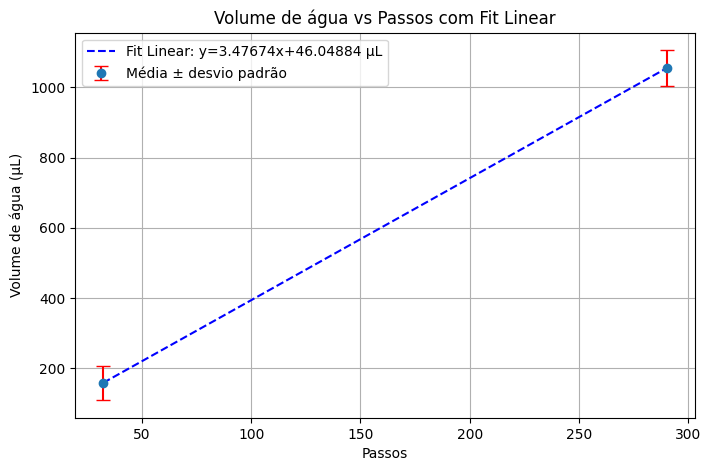

In [48]:
df = montar_dataframe(dados_brutos, peso_vazio)

df=fit_micropipeta(df)

In [49]:
dados_teste = {
    'Peso(g)': [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574],
    'Peso com líquido(g)': [2.421,2.466,2.421,2.444,2.517,2.553],
    'Valor teórico':[300]*6
}

df_teste = pd.DataFrame(dados_teste)


dados_teste = {
    'Peso (g)': [2.129,2.175,2.135,2.160,2.230,2.268],
    'Peso com líquido (g)': [2.234,2.279,2.239,2.260,2.331,2.369],
    'Valor teórico':[100]*6
}

df_teste = pd.DataFrame(dados_teste)

In [50]:
resultado_teste = validar_micropipeta(df_teste,'geral')


In [51]:
resultado_teste

,Peso (g),Peso com líquido (g),Valor teórico,Peso água (g),Volume experimental (µL),Erro absoluto (µL),Erro relativo (%)
0,2.129,2.234,100,0.105,105.315948,5.315948,5.315948
1,2.175,2.279,100,0.104,104.312939,4.312939,4.312939
2,2.135,2.239,100,0.104,104.312939,4.312939,4.312939
3,2.160,2.260,100,0.100,100.300903,0.300903,0.300903
4,2.230,2.331,100,0.101,101.303912,1.303912,1.303912
5,2.268,2.369,100,0.101,101.303912,1.303912,1.303912


In [52]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [2.225,2.225,2.223,2.225,2.223,2.222],
    'Valor teórico':[100]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"100ul")


In [53]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [2.246,2.245,2.245,2.243,2.242,2.243],
    'Valor teórico':[120]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"120ul")


In [54]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [2.325,2.324,2.325,2.326,2.324,2.326],
    'Valor teórico':[200]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"200ul")


In [55]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [2.421,2.424,2.427,2.422,2.422,2.423],
    'Valor teórico':[300]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"300ul")


In [56]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [2.624,2.621,2.621,2.622,2.622,2.623],
    'Valor teórico':[500]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"500ul")


In [64]:

dados_teste = {
    'Peso (g)': [2.124]*6,
    'Peso com líquido (g)': [3.120,3.121,3.122,3.120,3.122,3.120],
    'Valor teórico':[1000]*6
}

df_teste = pd.DataFrame(dados_teste)

resultado_teste = validar_micropipeta(df_teste,"1000ul")


In [65]:

# Criando o dicionário com os dados fornecidos
dados = {
    "Volume Desejado (µL)": [100, 120, 200, 300, 500, 1000],
    "Média dos volumes obtidos (µL)": [100.133735, 120.361083, 201.604814, 300.066867, 499.665664, 999.832832],
    "Erro Relativo (%)": [1.33316, 1.294879, 0.448559, 0.714469, 0.234513, 0.098615],
    "Erro Absoluto (µL)": [1.33316, 1.553855, 0.897119, 2.143406, 1.172563, 0.986151]
}

# Convertendo para DataFrame
df_micropipeta = pd.DataFrame(dados)

df_micropipeta.to_excel("Erros.xlsx", index=False)

